In [27]:
from collections import Counter
import json 

import joblib
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
import numpy as np


from common import Lematizator, cleaner, tokenizer, STOP_WORD_ES
# %matplotlib inline

# Load dataset and model
## dataset

In [2]:
file_path = [
    '../data/raw/uy_tweets_coronavirus_2020-04-09T09:19:19.598204.json',
#     '../data/raw/uy_tweets_covid19_2020-04-09T00:01:18.808683.json',
#     '../data/raw/uy_tweets_covid_19_2020-04-09T00:47:37.969046.json',
#     '../data/raw/uy_tweets_covid19uruguay_2020-04-08T20:45:11.934235.json',
#     '../data/raw/uy_tweets_covid_2020-04-09T02:48:43.809046.json',
#     '../data/raw/uy_tweets_quedateencasa_2020-04-09T01:48:09.328509.json',
]
tweets = []
for path in file_path:
    print(path)
    with open(path, 'r') as f:
        tweets.extend(json.load(f))

../data/raw/uy_tweets_coronavirus_2020-04-09T09:19:19.598204.json


In [3]:
cc = Counter([k['lang'] for k in tweets])
cc

Counter({'es': 58195,
         'en': 203,
         'und': 336,
         'ca': 268,
         'hu': 2,
         'pt': 42,
         'lt': 14,
         'cy': 2,
         'sv': 1,
         'fi': 1,
         'ro': 8,
         'fr': 14,
         'it': 8,
         'in': 1,
         'ru': 2,
         'de': 1})

In [4]:
dataset_uy = []
for tweet in tweets:
    keys_tw = ['created_at', 'id', 'full_text', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang']
    keys_usr = ['screen_name', 'location', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'verified', 'statuses_count', ]
    tw = {key: tweet[key]for key in keys_tw}
    usr = {'user_' + key: tweet['user'][key]for key in keys_usr}
    tw = {**tw, **usr}
    dataset_uy.append(tw)

## Models

In [29]:
model_path = '../models/linear/ensamble_multi_pipeline.joblib'
model = joblib.load(model_path)

# Make predictions

In [30]:
predictions = model.predict([k['full_text'] for k in dataset_uy])

Number of tweets for each class (negative, neutal, positive)

In [31]:
np.bincount(predictions+1)

array([ 7132, 39710, 12256])

## Testing tweets

In [32]:
idx = 1236
predictions[idx], dataset_uy[idx]['full_text']

(1,
 '@TelenocheUy Cuanto ponen el Pit Cnt para el fondo del coronavirus ??\nAún no oí  ni lei nada ....')

In [33]:
idx = 59
predictions[idx], dataset_uy[idx]['full_text']

(0,
 'Casi 89.000 muertos en el mundo por el #coronavirus, según el recuento de la AFP del jueves 9 de abril a las 11 horas GMT #AFP https://t.co/f8r7bpjlxZ https://t.co/pc29W4YRLL')

In [34]:
idx = 1119
predictions[idx], dataset_uy[idx]['full_text']

(-1,
 'La crisis económica la van a pagar los trabajadores y el Estado. Nunca el capital. El Fondo Coronavirus se paga con deuda nacional, jubilaciones y salarios públicos. Nunca el capital.')

# Results

/home/cesar/software/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


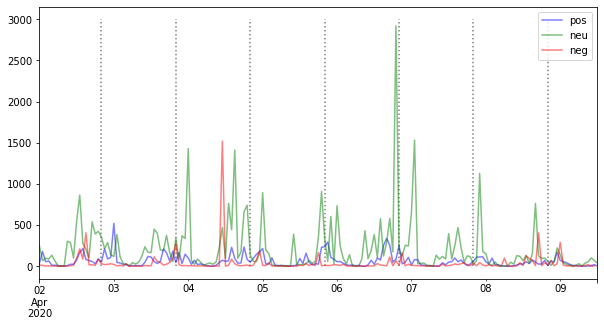

In [35]:
df = pd.Series(predictions, index=pd.to_datetime([k['created_at'] for k in dataset_uy]), name='date')

df = df[df.index>'2020-04-02']

pos = df[df==1]
neu = df[df==0] + 1 
neg = df[df==-1] + 2 

rule = '1H'
f, ax = plt.subplots(figsize=(10,5))
pos.resample(rule).sum().plot(ax=ax, label='pos', color='b', alpha=0.5)
neu.resample(rule).sum().plot(ax=ax, label='neu', color='g', alpha=0.5)
neg.resample(rule).sum().plot(ax=ax, label='neg', color='r', alpha=0.5)
for k in range(2, 9):
    ax.vlines(f'2020-04-0{k} 20:00:00', 0, 3000, linestyle=':', alpha=0.5)
ax.legend()
plt.show()

In [36]:
neg = [tweet['full_text'] for pred, tweet in zip(predictions, dataset_uy) if pred==-1]

In [39]:
neg[::1000]

['La crisis económica la van a pagar los trabajadores y el Estado. Nunca el capital. El Fondo Coronavirus se paga con deuda nacional, jubilaciones y salarios públicos. Nunca el capital.',
 '🎙 @ANIIuy hace distintos llamados para promover capacidades locales ante el coronavirus y piensa en qué hará el «día después» para que la innovación sirva de impulso a la economía: Lo charlamos con Fernando Brum (@fbrum34), presidente de ANII.\n\nhttps://t.co/7jtXhL0uDx https://t.co/t8djP2wvkm',
 'Atribuir, en Argentina, el default técnico de la deuda local, al coronavirus, es una gran tontería. Es el resultado lógico y previsible de un proceso de pésimas políticas económicas, que todavía traerá peores capítulos.',
 'Haciendo política con el Coronavirus. \nCuando gobernaba, a fin de enero, que no había que "crear pánico".\nAhora crea pánico diciendo que hay pocos tests. \nSi se diera cuenta del asco y la falta de respeto que genera, al menos se callaría la boca. https://t.co/5JBZSOH4pD',
 'Murió el 

In [40]:
pos = [tweet['full_text'] for pred, tweet in zip(predictions, dataset_uy) if pred==1]

In [41]:
pos[::1000]

['Presidente Lacalle Pou anunció que el 22 de abril se retomarán las clases en más de 900 escuelas rurales\n\nhttps://t.co/bNPgMokZgv',
 'Los #tests de #coronavirus no se hacían por un tema de plata. Ahora quedó todo arreglado. Los pagás vos https://t.co/2y40bK7lKU\nNo te olvides de aplaudir a las 9 de la noche. https://t.co/O36cblar4z',
 'Muchas gracias a nuestro personal por hacer posible cada día que contemos con ambientes limpios y seguros para vivir y trabajar.\nTodos seguiremos colaborando para superar este desafío.\nAl #Coronavirus #LeGanamosEntreTodos si #NosCuidamosEntreTodos https://t.co/HOB6626ZjP',
 'La OMS descarta que las mascarillas sean la “solución milagro” contra la pandemia de coronavirus #AFP https://t.co/tXYrvqh7UJ https://t.co/tj104iAHl1',
 'Esta bueno o morís ☣️envenenado o morís por el☢️virus pero seguro q si lo tomas CORONAVIRUS no vas a tener acá o en 👻 https://t.co/DDqMnziCHv',
 'Tristán Narvaja HOY\nSi se extiende el coronavirus que no señalen el proceder de

## Models

In [42]:
model_path = '../models/linear/mnb_multi_pipeline.joblib'
logit_model = joblib.load(model_path)

EOFError: 

# Make predictions

In [43]:
logit_predictions = logit_model.predict([k['full_text'] for k in dataset_uy])

NameError: name 'logit_model' is not defined

Number of tweets for each class (negative, neutal, positive)

In [ ]:
np.bincount(logit_predictions+1)

## Testing tweets

In [ ]:
idx = 1236
logit_predictions[idx], dataset_uy[idx]['full_text']

In [ ]:
idx = 59
logit_predictions[idx], dataset_uy[idx]['full_text']

In [ ]:
idx = 1119
logit_predictions[idx], dataset_uy[idx]['full_text']

# Results

In [ ]:
df = pd.Series(logit_predictions, index=pd.to_datetime([k['created_at'] for k in dataset_uy]), name='date')

df = df[df.index>'2020-04-02']

pos = df[df==1]
neu = df[df==0] + 1 
neg = df[df==-1] + 2 

rule = '1H'
f, ax = plt.subplots(figsize=(10,5))
pos.resample(rule).sum().plot(ax=ax, label='pos', color='b', alpha=0.5)
neu.resample(rule).sum().plot(ax=ax, label='neu', color='g', alpha=0.5)
neg.resample(rule).sum().plot(ax=ax, label='neg', color='r', alpha=0.5)
for k in range(2, 9):
    ax.vlines(f'2020-04-0{k} 20:00:00', 0, 3000, linestyle=':', alpha=0.5)
ax.legend()
plt.show()

In [ ]:
pos = [tweet['full_text'] for pred, tweet in zip(logit_predictions, dataset_uy) if pred==1]

In [ ]:
pos[9]